Here's a comprehensive notebook looking at how one can fit a rough WCS and then refined distortion map from all-sky camera images

All sky camera images can be downloaded from:
lsst-dev.ncsa.illinois.edu:/datasets/all-sky/visible

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import minimize
import glob
import os
import sys
import time

from read_stars import read_manual_stars

from lsst.all_sky_phot.wcs import wcs_zea, wcs_refine_zea, Fisheye, distortion_mapper, distortion_mapper_looper
from lsst.all_sky_phot import phot_night, readcr2, readYBC, radec2altaz

from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, Longitude, Latitude
import astropy.units as u
from astropy.time import Time
from astropy.table import Table, vstack
from astropy import units as u

from photutils import CircularAperture

Using a star map and ds9, put together a file listing the x,y,mjd positions of known stars. Uses astroquery to look up the RA,Dec of the stars, then computes the alt,az for the mjds.

In [2]:
# Read in stars measured off several exposures
stars = read_manual_stars('starcoords.dat')
stars

array([ ('Achernar',  3441.,  2918.,  57415.03236111,  49.94698828,  215.12809734),
       ('Achernar',  3576.,  3018.,  57415.06576389,  43.71539346,  217.98735235),
       ('Betelgeuse',  2123.,   971.,  57415.01190972,  43.31994349,   40.9842762 ),
       ('Betelgeuse',  2330.,   956.,  57415.03236111,  47.12271402,   32.09165422),
       ('Betelgeuse',  2677.,   949.,  57415.06576389,  51.30179875,   14.88602947),
       ('Canopus',  2221.,  2671.,  57415.01190972,  55.59327709,  141.12221375),
       ('Canopus',  2338.,  2640.,  57415.03236111,  59.41774533,  145.43966508),
       ('Canopus',  2539.,  2609.,  57415.06576389,  64.53282837,  156.57108675),
       ('Procyon',  1418.,  1164.,  57415.01190972,  26.77830662,   65.70781923),
       ('Procyon',  1610.,  1115.,  57415.03236111,  32.4629146 ,   60.33905779),
       ('Procyon',  1935.,  1053.,  57415.06576389,  41.01235255,   49.78487361),
       ('Rigel',  2400.,  1377.,  57415.01190972,  61.91628458,   42.05746098),
      

Find the WCS that best matches up the catalog positions to the observed positions. For this and the later WCS fitting, I minimize the median distance between the catalog stars and their nearest neighbor. This basically assumes there are more detected objects than catalog objects, and the median should toss out the rare cases where a catalog star is not in the detected catalog.

This does not use any brightess information, but there are hooks in place to minimize the 3-dimensional distance between catalog and observed stars, where the magnitudes could be folded in.

In [3]:
# Fit a Zenith Equal Area projection.
fun = wcs_zea(stars['x'], stars['y'], stars['alt'], stars['az'], crpix1=2.87356521e+03, crpix2=1.98559533e+03)
x0 = np.array([2.87356521e+03,   1.98559533e+03,  1., 1., .036,
        0.0027,  0.00295,   -0.0359])
fit_result = minimize(fun, x0)

In [4]:
# Convert the fit to a full WCS object
wcs_initial = fun.return_wcs(fit_result.x)

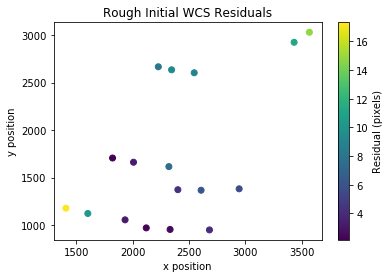

In [5]:
# Check the residuals
fit_x, fit_y = wcs_initial.all_world2pix(stars['az'], stars['alt'], 0)
resid_d = ((fit_x-stars['x'])**2+(fit_y-stars['y'])**2)**0.5
plt.scatter(fit_x, fit_y, c=resid_d)
cb = plt.colorbar()
cb.set_label('Residual (pixels)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Rough Initial WCS Residuals')

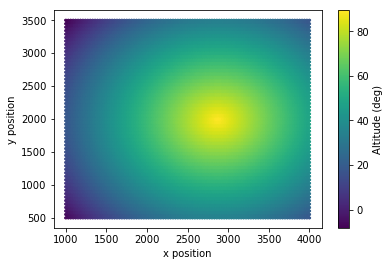

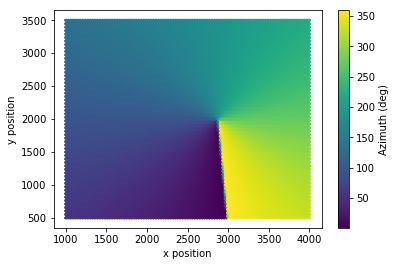

In [6]:
# Let's see what the result looks like
x, y = np.meshgrid(np.arange(1000,4000, 1), np.arange(500, 3500, 1))
x = x.ravel()
y = y.ravel()
az, alt = wcs_initial.all_pix2world(x,y, 0)
plt.hexbin(x,y, alt)
plt.xlabel('x position')
plt.ylabel('y position')
cb = plt.colorbar()
cb.set_label('Altitude (deg)')
plt.figure()
plt.hexbin(x,y, az)
plt.xlabel('x position')
plt.ylabel('y position')
cb = plt.colorbar()
cb.set_label('Azimuth (deg)')

In [7]:
# Now to run photometry on a full image and refine the WCS solution
# Load the Yale bright star catalog
ybc = readYBC()

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/pandas/io/parsers.py:710: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


Read in an example frame (clear, dark time). Run detection and photometry on it.

In [8]:
filename = 'ut012716/ut012716.0130.long.cr2'
#filename = 'ut012516/ut012516.0322.long.cr2'
im, header = readcr2(filename)
# Combine the RGB into a single image
sum_image = np.sum(im, axis=2).astype(float)
# Run detection and photometry
phot_tables = phot_night([filename], savefile=None, progress_bar=False)
phot_appertures = CircularAperture( (phot_tables[0]['xcenter'], phot_tables[0]['ycenter']), r=5.)
# guess the camera zeropoint
zp = -18.
measured_mags = -2.5*np.log10(phot_tables[0]['residual_aperture_sum'].data) - zp

In [9]:
# OK, let's see where we expect the stars to be
lsst_location = EarthLocation(lat=-30.2444*u.degree, lon=-70.7494*u.degree, height=2650.0*u.meter)
alt_cat, az_cat = radec2altaz(ybc['RA'].values, ybc['Dec'].values, header['mjd'], location=lsst_location)
above = np.where(alt_cat > 5.)
x_expected, y_expected = wcs_initial.all_world2pix(az_cat[above], alt_cat[above], 0.)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/pyt

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


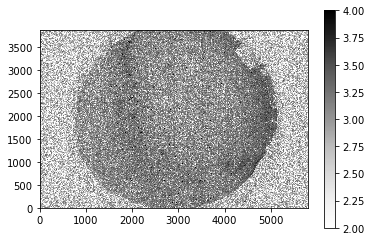

In [10]:
# Let's take a look at where the stars are, and where predicted stars are:
plt.imshow(np.log10(sum_image),  cmap='Greys', origin='lower', vmin=2, vmax=4)
plt.colorbar()

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


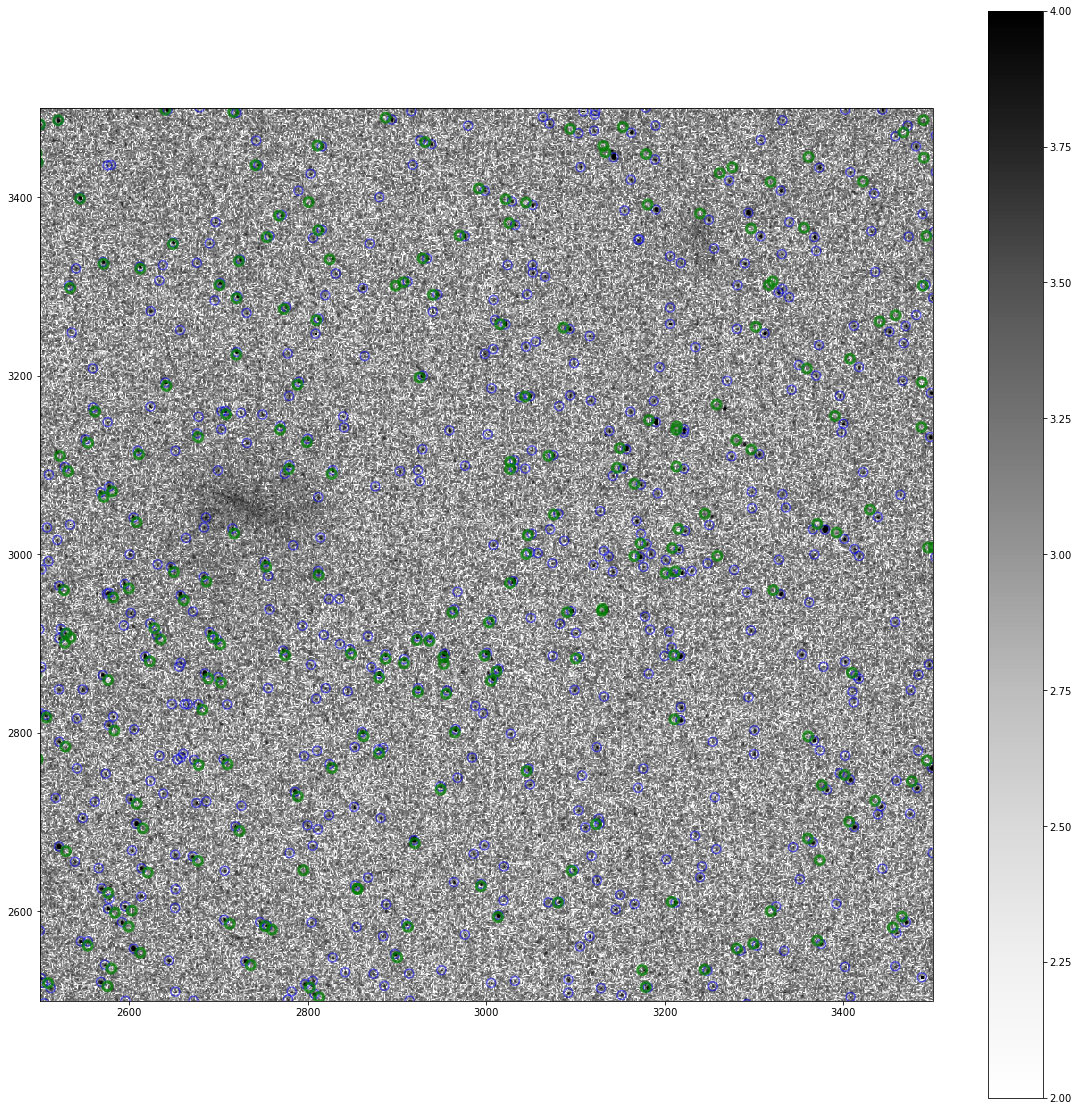

In [11]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(sum_image),  cmap='Greys', origin='lower', vmin=2, vmax=4)
plt.colorbar()
plt.xlim([2500,3500])
plt.ylim([2500,3500])
# Detected objects in blue
phot_appertures.plot(color='blue', lw=1.5, alpha=0.5)
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.75)

In [12]:
x0

array([  2.87356521e+03,   1.98559533e+03,   1.00000000e+00,
         1.00000000e+00,   3.60000000e-02,   2.70000000e-03,
         2.95000000e-03,  -3.59000000e-02])

So, looks like the fit isn't that good. Not surprising since it was off a handful of stars measured by hand.
 Let's refine the fit. By default, not using the magnitude info.
 
Now, use a full frame. Takes all the stars in the catalog above some limit (15 degrees by default), and tries to match them to the observed detections. 

In [13]:
fun = wcs_refine_zea(phot_tables[0]['xcenter'].value, phot_tables[0]['ycenter'].value, measured_mags,header['mjd'],
                     ybc['RA'].values, ybc['Dec'].values, ybc['Vmag'].values, a_order=0, b_order=0)
x0 = fun.wcs2x0(wcs_initial)
fit_result = minimize(fun, x0[0:8], method='Powell')

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/pyt

In [14]:
# Check that we did imporved the fit
fun(fit_result.x) < fun(x0[0:8])

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


True

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


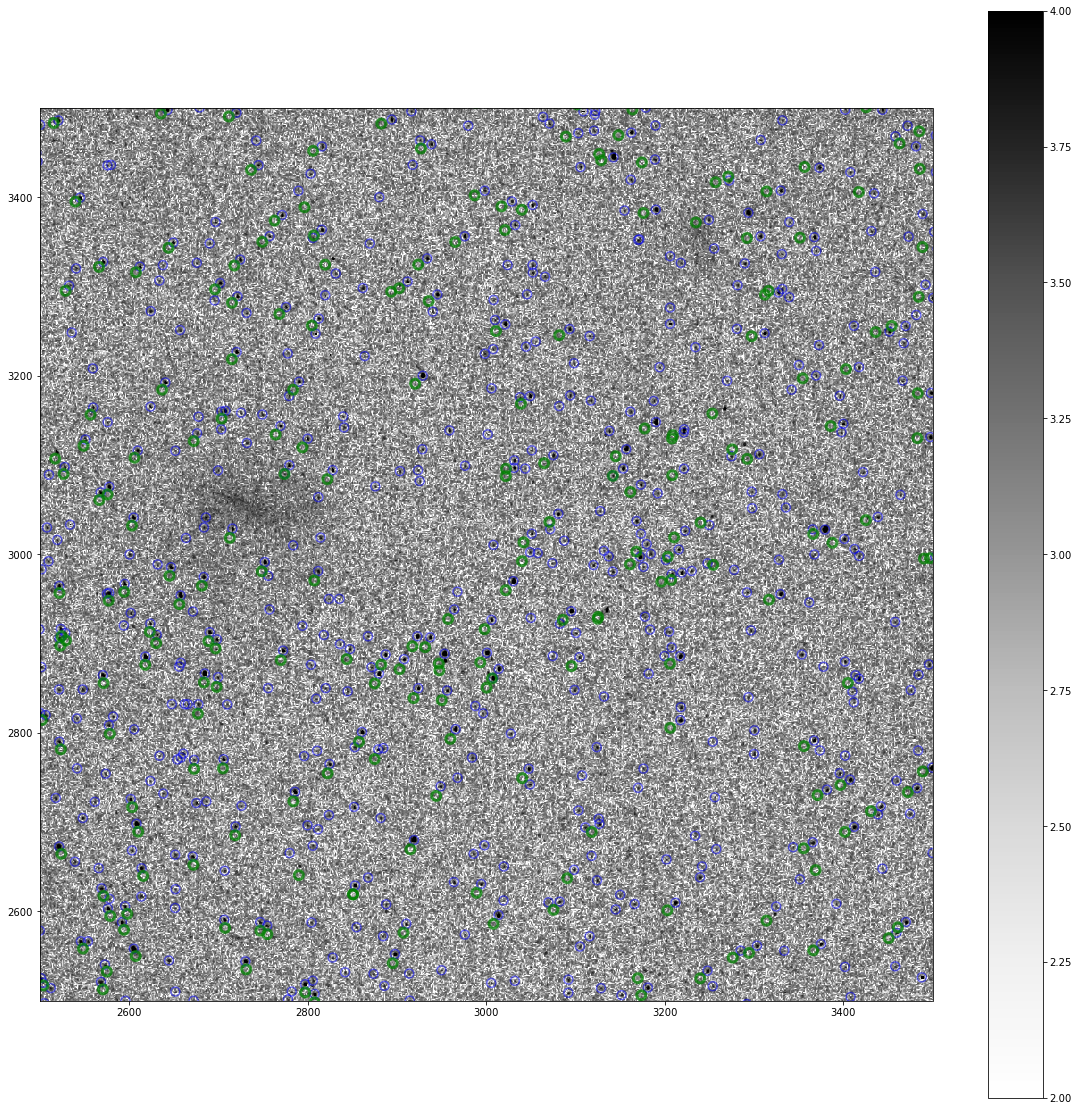

In [15]:
# Let's update the expected position of reference stars and see how we did
wcs_refined = fun.return_wcs(fit_result.x)
x_expected, y_expected = wcs_refined.all_world2pix(az_cat[above], alt_cat[above], 0.)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

plt.figure(figsize=[20,20])
plt.imshow(np.log10(sum_image),  cmap='Greys', origin='lower', vmin=2, vmax=4)
plt.colorbar()
plt.xlim([2500,3500])
plt.ylim([2500,3500])
phot_appertures.plot(color='blue', lw=1.5, alpha=0.5)
apertures.plot(color='green', lw=3, alpha=0.75)

Looks like the expected positions are still shifted from the actual pixel positions. I was never able to get the SIP distortion terms to converge and get a significantly better fit. Let's just brute-force map out the distortions. 

Now to run detection and photometry on an entire night worth of data. 

In [16]:
# Run one night to fit, and the next to check the solution
roots = ['012616', '012716']
for root in roots:
    savefile = root+'_night_phot.npz'
    # Don't bother if already run
    if not os.path.isfile(savefile):
        files = glob.glob('ut'+root+'/*.cr2')
        phot_tables = phot_night(files, savefile=savefile, verbose=False)

In [17]:
# Load up the photometry tables from the 1st night
temp = np.load('012716_night_phot.npz')
phot_tables = temp['phot_tables'][()]
temp.close()


This is a brute force mapping of the distortion. Go over a grid, find all the stars that are expected from the catalog and that are detected in multiple frames, and find the best x and y shifts that line them up (minimize the median distance to nearest neighbor). I use kdtrees, but this is still a bit slow. 

In [18]:
# Which photometry tables to use
minindx=50
maxindx=91

# Build arrays of observed and expected locations
alts = []
azs = []
mjds = []
observed_x = []
observed_y = []
observed_mjd = []
for phot_table in phot_tables[minindx:maxindx]:
    mjd = phot_table['mjd'][0]
    alt, az = radec2altaz(ybc['RA'].values, ybc['Dec'].values, mjd, location=lsst_location)
    good = np.where(alt > 0.)
    alts.append(alt[good])
    azs.append(az[good])
    mjds.append(az[good]*0+mjd)
    observed_x.append(phot_table['xcenter'].value)
    observed_y.append(phot_table['ycenter'].value)
    observed_mjd.append(phot_table['mjd'].data)

alts = np.concatenate(alts)
azs = np.concatenate(azs)
mjds = np.concatenate(mjds)
print('Predicting %i star locations' % mjds.size)
observed_x = np.concatenate(observed_x)
observed_y = np.concatenate(observed_y)
observed_mjd = np.concatenate(observed_mjd)


/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/pyt

Predicting 192346 star locations


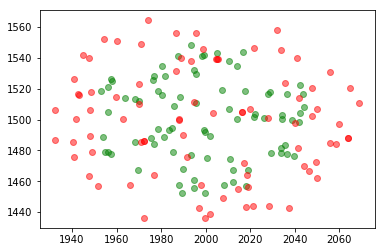

In [33]:
## let's spot check some distortion mapping
window=50
u_center = 2000
v_center= 1500
fit_result, ax = distortion_mapper(observed_x, observed_y, observed_mjd, alts, azs, mjds,
                                   wcs_refined, window=window, u_center=u_center,
                                   v_center=v_center, diaog=True)


In [34]:
fit_result

   direc: array([[ 1.        ,  0.        ],
       [ 0.00282358, -0.00203344]])
     fun: 26.510123511085101
 message: 'Optimization terminated successfully.'
    ncat: 81
    nfev: 69
     nit: 2
    nobs: 85
  status: 0
 success: True
       x: array([-2.20846841,  1.59536265])

In [ ]:
t0 = time.time()
filename='fit_result_%i_%i.npz' % (minindx, maxindx)
# Number of points to make in x and y
#nx=70
#ny=50

nx=70
ny=50

window=50  #50

if not os.path.isfile(filename):
    wcs_w_shift, result = distortion_mapper_looper(observed_x, observed_y, observed_mjd, alts, azs, mjds,
                                                  wcs_refined, xmax=5796, ymax=3870, nx=nx, ny=ny,
                                                  window=window)
    # unpack variables for convienence
    yp = result['yp']
    xp = result['xp']
    xshifts = result['xshifts']
    yshifts = result['yshifts']
    distances = result['distances']
    npts = result['npts']
    np.savez(filename, xp=result['xp'], yp=result['yp'], xshifts=result['xshifts'], yshifts=result['yshifts'],
             distances=result['distances'], npts=result['npts'])
else:
    data = np.load(filename)
    yp = data['yp'].copy()
    xp = data['xp'].copy()
    xshifts = data['xshifts'].copy()
    yshifts = data['yshifts'].copy()
    distances = data['distances'].copy()
    npts = data['npts'].copy()
    data.close()
    good = np.where(~(np.isnan(xshifts)) & ~(np.isnan(yshifts)))
    wcs_w_shift = Fisheye(wcs_refined, xp[good], yp[good], xshifts[good], yshifts[good])
t1 = time.time()
print('time to map distortions = %.1f min' % ( (t1-t0)/60.))

> /Users/yoachim/gitRepos/all_sky_phot/python/lsst/all_sky_phot/wcs/fisheye_map.py(282)distortion_mapper_looper()
-> fit_result = distortion_mapper(observed_x, observed_y, observed_mjd, catalog_alt,
(Pdb) u_center=3000
(Pdb) v_center=3000
(Pdb) fit_result = distortion_mapper(observed_x, observed_y, observed_mjd, catalog_alt,                                            catalog_az, catalog_mjd, wcs, window=window,                                            u_center=u_center, v_center=v_center)
(Pdb) fit_result
   direc: array([[  1.00000000e+00,   0.00000000e+00],
       [  1.26858848e-05,   1.99669358e-05]])
     fun: 0.77747446219355054
 message: 'Optimization terminated successfully.'
    ncat: 120
    nfev: 231
     nit: 5
    nobs: 181
  status: 0
 success: True
       x: array([ 6.37261445,  9.77709166])
--KeyboardInterrupt--


In [ ]:
# Look at the distortion map that we have to apply after the WCS solution
plt.scatter(xp,yp, c=xshifts, vmin=-15, vmax=10, s=40)
cb = plt.colorbar()
cb.set_label('x-shift (pix)')
plt.figure()
plt.scatter(xp,yp, c=yshifts, vmin=-15, vmax=10, s=40)
cb = plt.colorbar()
cb.set_label('y-shift (pix)')

In [ ]:
plt.scatter(xp,yp, c=npts, vmin=10, vmax=100)
cb = plt.colorbar()

In [ ]:
plt.scatter(xp,yp, c=distances, s=40, vmax=3)
cb = plt.colorbar()
cb.set_label('Median distance to nearest neighbor (pix)')

In [ ]:
x_expected, y_expected = wcs_w_shift.all_world2pix(az_cat[above], alt_cat[above], 0)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

plt.figure(figsize=[20,20])
plt.imshow(np.log10(sum_image),  cmap='Greys', origin='lower', vmin=2, vmax=4)
plt.colorbar()
plt.xlim([2500,3500])
plt.ylim([2500,3500])
phot_appertures.plot(color='blue', lw=3.5, alpha=0.5)
apertures.plot(color='green', lw=3, alpha=0.5)

In [ ]:

plt.figure(figsize=[20,20])
plt.imshow(np.log10(sum_image),  cmap='Greys', origin='lower', vmin=2, vmax=4)
plt.colorbar()
plt.xlim([2500, 4000])
plt.ylim([1500,2500])
phot_appertures.plot(color='blue', lw=1.5, alpha=0.5)
apertures.plot(color='green', lw=3, alpha=0.75)

In [ ]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(sum_image),  cmap='Greys', origin='lower', vmin=2, vmax=4)
plt.colorbar()
plt.xlim([1000, 2500])
plt.ylim([0,1500])
phot_appertures.plot(color='blue', lw=1.5, alpha=0.5)
apertures.plot(color='green', lw=3, alpha=0.75)

In [ ]:
# Let's check an image from a different night
#filename = 'ut012716/ut012716.0130.long.cr2'
filename = 'ut012516/ut012516.0322.long.cr2'
im, header = readcr2(filename)
# Combine the RGB into a single image
sum_image = np.sum(im, axis=2).astype(float)
# Run detection and photometry
phot_tables = phot_night([filename], savefile=None, progress_bar=False)
phot_appertures = CircularAperture( (phot_tables[0]['xcenter'], phot_tables[0]['ycenter']), r=5.)
# guess the camera zeropoint
zp = -18.
measured_mags = -2.5*np.log10(phot_tables[0]['residual_aperture_sum'].data) - zp

In [ ]:
alt_cat, az_cat = radec2altaz(ybc['RA'].values, ybc['Dec'].values, header['mjd'], location=lsst_location)
above = np.where(alt_cat > 5.)
x_expected, y_expected = wcs_initial.all_world2pix(az_cat[above], alt_cat[above], 0.)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

In [ ]:
x_expected, y_expected = wcs_w_shift.all_world2pix(az_cat[above], alt_cat[above], 0)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

plt.figure(figsize=[20,20])
plt.imshow(np.log10(sum_image),  cmap='Greys', origin='lower', vmin=3, vmax=5)
plt.colorbar()
plt.xlim([2500,3500])
plt.ylim([2500,3500])
phot_appertures.plot(color='blue', lw=3.5, alpha=0.5)
apertures.plot(color='green', lw=3, alpha=0.5)

In [ ]:
plt.imshow(np.log10(sum_image),  cmap='Greys', origin='lower')


In [ ]:
# OK, since this looks good, let's save the wcs solution with distortion map
wcs_w_shift.save('fisheye_wcs.npz')